# Evaluación 5

**Integrantes:**

+ Integrante 1: Ricardo Alejandro Yañez Rios
+ Integrante 2: Alvaro Concha Gutierrez

**Fecha de Entrega:** Julio 2025  
**Versión:** 1.0  

---

## Descripción

Este notebook contiene el desarrollo de la evaluación 5 de la asignatura de Inteligencia Artificial de la carrera Ingeniería Civil en Informática de la Universidad del Biío Bío - Sede Concepción

---

## Requisitos de Software

Este notebook fue desarrollado con Python 3.9. A continuación se listan las bibliotecas necesarias:

In [ ]:
import numpy as np
import tensorflow as tf

from tensorflow import keras
from matplotlib import pyplot as plt
import time
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from keras.optimizers import AdamW

In [ ]:
# Optimizacion, veamos si la GPU esta activada (en colab utilize T4)
from tensorflow.keras.mixed_precision import set_global_policy
from tensorflow.python.client import device_lib
gpus = tf.config.list_physical_devices('GPU')
usando_gpu = len(gpus) > 0
print(device_lib.list_local_devices())

# Definir tamaño de batch base
x_batch_size = 64

# Aumentar batch size si hay GPU y activar float16 (esto reduce la precision de float, pero los resultados no son tan afectados y es muchisimo mas rapido en la GPU)
if usando_gpu:
    x_batch_size = 256
    set_global_policy('mixed_float16')

print(f'tamaño batch: {x_batch_size}')

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 1830666108964992050
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14619377664
locality {
  bus_id: 1
  links {
  }
}
incarnation: 5072861545824363391
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
xla_global_id: 416903419
]
tamaño batch: 256


In [ ]:
# Setea los seed para números random

np.random.seed(29)
tf.random.set_seed(29)

In [ ]:
# Carga datos de entrenamiento y prueba de CIFAR10

(imgs_train,labs_train), (imgs_test,labs_test) = keras.datasets.cifar10.load_data()
print(imgs_train.shape)
print(imgs_test.shape)

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step
(50000, 32, 32, 3)
(10000, 32, 32, 3)


In [ ]:
np.unique(labs_train)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [ ]:
# Lista de nombres para usar como etiquetas

nombres = ['avión', 'auto', 'pájaro', 'gato', 'venado', 'perro', 'rana', 'caballo', 'barco', 'camión']

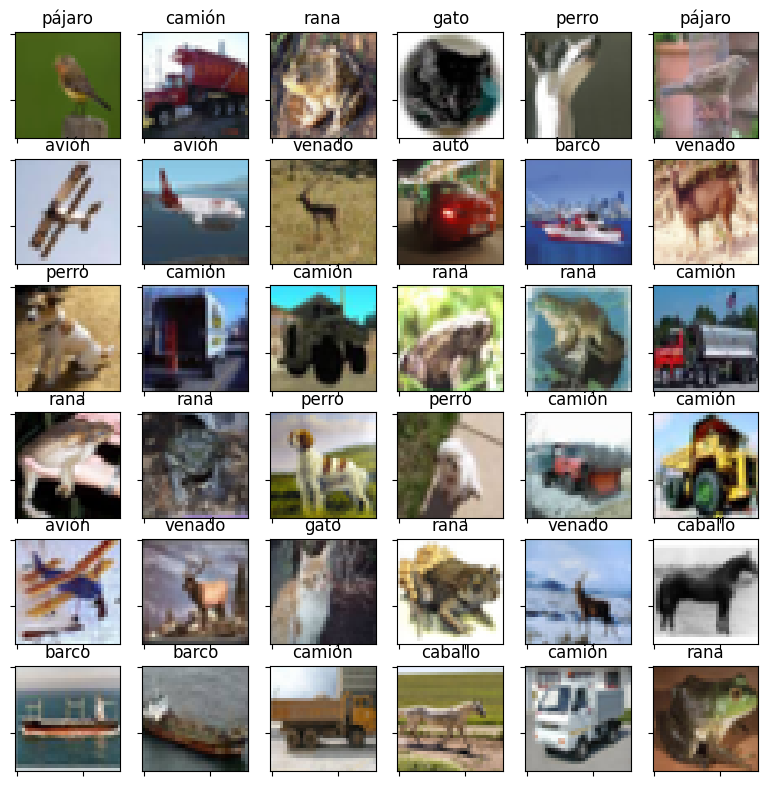

In [ ]:
# Muestra una grilla de ejemplos (al azar)

h = 6 # alto de la grilla
w = 6 # ancho de la grilla
fig, axs = plt.subplots(h, w, figsize=(1.6*h,1.6*w))
for i in range(h):
  for j in range(w):
    ex = np.random.randint(len(imgs_train))
    axs[i,j].set_title(nombres[labs_train[ex][0]])
    axs[i,j].grid(False)
    axs[i,j].set_xticklabels([])
    axs[i,j].set_yticklabels([])
    axs[i,j].imshow(imgs_train[ex])

In [ ]:
# Tranforma los datos para el entrenamiento,
# Necesita transformar tanto el train como el test

X_train = imgs_train.reshape(50000,32*32*3)
X_test = imgs_test.reshape(10000,32*32*3)
# Normaliza
X_train = X_train / 255
X_test = X_test / 255

print('X', X_train.shape, X_test.shape)

Y_train = keras.utils.to_categorical(labs_train, 10)
Y_test = keras.utils.to_categorical(labs_test, 10)

print('Y', Y_train.shape, Y_test.shape)

X (50000, 3072) (10000, 3072)
Y (50000, 10) (10000, 10)


In [ ]:
# Cantidad de ejemplos, neuronas de entrada y neuronas de salida

M = X_train.shape[0]
N = X_train.shape[1]
C = Y_train.shape[1]

print(M,N,C)

50000 3072 10


In [ ]:
# Crea la red feed-forward (tiene 3 capas escondidas!)

h1 = 512
h2 = 256

red = keras.Sequential(name="Red_Evaluacion")
red.add(layers.Input(shape=(N,), name='entrada'))
red.add(layers.Dense(h1, activation='relu', name="Primera_capa"))
red.add(layers.Dense(h2, activation='relu', name="Segunda_capa"))
red.add(layers.Dense(h2, activation='relu', name="Tercera_capa"))
red.add(layers.Dense(C, activation='softmax', name="Capa_salida"))

red.summary()

red.compile(
    loss='categorical_crossentropy',
    optimizer='sgd',
    metrics=['accuracy']
)

Model: "Red_Evaluacion"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Primera_capa (Dense)            │ (None, 512)            │     1,573,376 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Segunda_capa (Dense)            │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Tercera_capa (Dense)            │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Capa_salida (Dense)             │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,773,066 (6.76 MB)

 Trainable params: 1,773,066 (6.76 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Entrena la red
num_epocas = 5
start_time1 = time.time()
history1 = red.fit(X_train, Y_train, epochs = num_epocas, batch_size=x_batch_size, validation_data=(X_test,Y_test))
end_time1 = time.time()

Epoch 1/5
196/196 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.2015 - loss: 2.1858 - val_accuracy: 0.2817 - val_loss: 1.9775
Epoch 2/5
196/196 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.3247 - loss: 1.9163 - val_accuracy: 0.3099 - val_loss: 1.8975
Epoch 3/5
196/196 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.3546 - loss: 1.8335 - val_accuracy: 0.3266 - val_loss: 1.8523
Epoch 4/5
196/196 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.3726 - loss: 1.7862 - val_accuracy: 0.3391 - val_loss: 1.8155
Epoch 5/5
196/196 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.3843 - loss: 1.7485 - val_accuracy: 0.3482 - val_loss: 1.7879


# Evaluación

## Experimentación

### Agregar más capas o más neuronas

Nota. Uno de los experimentos DEBE obtener un accuracy superior al 90%

#### Experimento 1 - 1 punto

In [ ]:
red = keras.Sequential(name="FFN_Mejorada")
red.add(layers.Input(shape=(X_train.shape[1],), name='entrada'))

# Bloque 1
red.add(layers.Dense(2048, activation='relu'))
red.add(layers.BatchNormalization())
red.add(layers.Dropout(0.4))

# Bloque 2
red.add(layers.Dense(1024, activation='relu'))
red.add(layers.BatchNormalization())
red.add(layers.Dropout(0.4))

# Bloque 3
red.add(layers.Dense(512, activation='relu'))
red.add(layers.BatchNormalization())
red.add(layers.Dropout(0.3))

# Bloque 4
red.add(layers.Dense(256, activation='relu'))
red.add(layers.BatchNormalization())

# Capa de salida
red.add(layers.Dense(10, activation='softmax'))

# Compilar con AdamW
red.compile(
    loss='categorical_crossentropy',
    optimizer=AdamW(learning_rate=1e-3, weight_decay=1e-5),
    metrics=['accuracy']
)

# Entrenar
start_time2 = time.time()
history2 = red.fit(
    X_train, Y_train,
    epochs=200,
    batch_size=x_batch_size,
    validation_data=(X_test, Y_test),
    verbose=1
)
end_time2 = time.time()

Epoch 1/200
196/196 ━━━━━━━━━━━━━━━━━━━━ 20s 51ms/step - accuracy: 0.2673 - loss: 2.2031 - val_accuracy: 0.3597 - val_loss: 1.8027
Epoch 2/200
196/196 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.3951 - loss: 1.6953 - val_accuracy: 0.3688 - val_loss: 1.7606
Epoch 3/200
196/196 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.4229 - loss: 1.6081 - val_accuracy: 0.3214 - val_loss: 1.9891
Epoch 4/200
196/196 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.4439 - loss: 1.5527 - val_accuracy: 0.3650 - val_loss: 1.7599
Epoch 5/200
196/196 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.4592 - loss: 1.5148 - val_accuracy: 0.3140 - val_loss: 1.9922
Epoch 6/200
196/196 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.4659 - loss: 1.4961 - val_accuracy: 0.3675 - val_loss: 1.8178
Epoch 7/200
196/196 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.4672 - loss: 1.4837 - val_accuracy: 0.4380 - val_loss: 1.5629
Epoch 8/200
196/196 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.4756 - loss: 1.4675 - val_ac

#### Experimento 2 - 1 punto

In [ ]:
# cargar datos y normalizar
x_train = imgs_train.astype('float32') / 255.0
x_test = imgs_test.astype('float32') / 255.0
y_train = keras.utils.to_categorical(labs_train, 10)
y_test = keras.utils.to_categorical(labs_test, 10)

# data augmentation
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
)
datagen.fit(x_train)

# definir modelo
model = keras.Sequential([
    keras.Input(shape=(32, 32, 3)), layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Dropout(0.3),

    layers.Conv2D(128, (3, 3), padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.Conv2D(128, (3, 3), padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Dropout(0.4),

    layers.Conv2D(256, (3, 3), padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.Conv2D(256, (3, 3), padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Dropout(0.4),

    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),

    # esto le dice de forma explicita a esa capa final que sus pesos y salidas estén en float32, sin importar la politica global de float (float16 si es gpu)
    layers.Dense(10, activation='softmax', dtype='float32')
])

# compilar modelo con optimizador robusto
opt = keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)
model.compile(optimizer=opt,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# entrenar con EarlyStopping
early_stop = EarlyStopping(monitor='val_accuracy', patience=15, restore_best_weights=True)

# entrenar
start_time3 = time.time()
history3 = model.fit(
    datagen.flow(x_train, y_train, batch_size=x_batch_size),
    validation_data=(x_test, y_test),
    epochs=200,
    callbacks=[early_stop],
    verbose=1
)
end_time3 = time.time()

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/200
196/196 ━━━━━━━━━━━━━━━━━━━━ 75s 214ms/step - accuracy: 0.2765 - loss: 2.4036 - val_accuracy: 0.1899 - val_loss: 2.6157
Epoch 2/200
196/196 ━━━━━━━━━━━━━━━━━━━━ 26s 133ms/step - accuracy: 0.4624 - loss: 1.4918 - val_accuracy: 0.4067 - val_loss: 1.6955
Epoch 3/200
196/196 ━━━━━━━━━━━━━━━━━━━━ 26s 133ms/step - accuracy: 0.5209 - loss: 1.3257 - val_accuracy: 0.5635 - val_loss: 1.2379
Epoch 4/200
196/196 ━━━━━━━━━━━━━━━━━━━━ 26s 134ms/step - accuracy: 0.5642 - loss: 1.2127 - val_accuracy: 0.4636 - val_loss: 1.7147
Epoch 5/200
196/196 ━━━━━━━━━━━━━━━━━━━━ 26s 134ms/step - accuracy: 0.5960 - loss: 1.1209 - val_accuracy: 0.5827 - val_loss: 1.2518
Epoch 6/200
196/196 ━━━━━━━━━━━━━━━━━━━━ 26s 134ms/step - accuracy: 0.6238 - loss: 1.0467 - val_accuracy: 0.5644 - val_loss: 1.3647
Epoch 7/200
196/196 ━━━━━━━━━━━━━━━━━━━━ 26s 135ms/step - accuracy: 0.6496 - loss: 0.9810 - val_accuracy: 0.6147 - val_loss: 1.2118
Epoch 8/200
196/196 ━━━━━━━━━━━━━━━━━━━━ 40s 132ms/step - accuracy: 0.6652 -

### Descripción de arquitectura de las redes de los experimentos

#### Red experimento 1 - 1 punto

##### **Arquitectura de la Red Neuronal Feedforward Mejorada (FFN_Mejorada)**

Esta arquitectura corresponde a una red neuronal completamente conectada (feedforward o densamente conectada) diseñada para clasificación multiclase, con salida de 10 clases. Se ha optimizado usando técnicas modernas de regularización y normalización.

##### **Estructura General**
red = keras.Sequential(name="FFN_Mejorada")

Se utiliza el modelo secuencial de Keras para construir la red capa por capa.

##### **Capa de Entrada**

    red.add(layers.Input(shape=(X_train.shape[1],), name='entrada'))

Toma como entrada un vector de características (dimensión igual a la cantidad de columnas de X_train).

No realiza ninguna operación, solo define la forma esperada de entrada.

##### **Bloques Intermedios**

Cada bloque consiste en:
* Capa Densa: una capa totalmente conectada con activación ReLU.
* Batch Normalization: normaliza la salida de la capa anterior para estabilizar y acelerar el entrenamiento.
* Dropout: apaga aleatoriamente una fracción de las neuronas durante el entrenamiento para evitar el sobreajuste.

##### **Bloques 1**
    Dense(2048) + BatchNorm + Dropout(0.4)

##### **Bloques 2**
    Dense(1024) + BatchNorm + Dropout(0.4)

##### **Bloques 3**
    Dense(512) + BatchNorm + Dropout(0.3)

##### **Bloques 4**
    Dense(256) + BatchNorm

*Este último bloque no tiene dropout, lo que puede indicar que se busca preservar más información antes de la capa de salida.*

##### **Capa de Salida**
    Dense(10, activation='softmax')

Produce 10 probabilidades (una por clase) y usa softmax para convertir los valores en una distribución de probabilidad válida.

##### **Compilación del Modelo**
    optimizer=AdamW(learning_rate=1e-3, weight_decay=1e-5)

Se utiliza AdamW, una variante de Adam que incluye decaimiento de pesos explícito (weight_decay) para mejor regularización.

La función de pérdida usada es categorical_crossentropy, ideal para clasificación multiclase con etiquetas codificadas one-hot.

Se monitorea la métrica de accuracy.

**El modelo se entrena por 200 epochs.**

#### Red experimento 2 - 1 punto

##### **Arquitectura CNN**
En esta arquitectura se han incorporado técnicas modernas de regularización y aumento de datos para mejorar la capacidad de generalización del modelo.

##### **Preprocesamiento de Datos**
    x_train = imgs_train.astype('float32') / 255.0
    x_test = imgs_test.astype('float32') / 255.0

Normalización de imágenes al rango [0, 1].

    y_train = keras.utils.to_categorical(labs_train, 10)
    y_test = keras.utils.to_categorical(labs_test, 10)

Codificación one-hot de las etiquetas (10 clases).

##### **Aumento de Datos (Data Augmentation)**
    datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    )

* Rotaciones hasta 15°
* Desplazamientos horizontales y verticales hasta un 10%
* Volteo horizontal aleatorio
* Aumenta la variedad del conjunto de entrenamiento sin recopilar más datos.

##### **Arquitectura del Modelo CNN**
    model = keras.Sequential([...])

El modelo está compuesto por múltiples bloques convolucionales, seguidos por capas densas:

##### **Entrada**
    keras.Input(shape=(32, 32, 3))

Entrada de imágenes de 32x32 con 3 canales RGB.

##### **Bloques Convolucionales**
Cada bloque sigue la estructura:

    Conv2D → BatchNormalization → Conv2D → BatchNormalization → MaxPooling → Dropout

##### **Bloque 1**
    Conv2D(64) → BN → Conv2D(64) → BN → MaxPool → Dropout(0.3)

##### **Bloque 2**
    Conv2D(128) → BN → Conv2D(128) → BN → MaxPool → Dropout(0.4)

##### **Bloque 3**
    Conv2D(256) → BN → Conv2D(256) → BN → MaxPool → Dropout(0.4)

Batch Normalization estabiliza el entrenamiento y acelera la convergencia.
Dropout mitiga el sobreajuste desconectando aleatoriamente neuronas.

##### **Capas Densas**
Después de aplanar la salida convolucional:

    Flatten → Dense(512, ReLU) → BN → Dropout(0.5)

La capa densa de 512 neuronas capta relaciones de alto nivel.
Dropout más agresivo en esta etapa.

##### **Capa de Salida**
    Dense(10, activation='softmax', dtype='float32')

10 neuronas de salida (una por clase).

Activación softmax para probabilidades.

*dtype='float32' asegura precisión estándar aunque se use política de float16 (útil para aceleradores como GPU o TPU).*

##### **Compilación del Modelo**
    optimizer = SGD(learning_rate=0.01, momentum=0.9)

Se utiliza el optimizador SGD con momentum, robusto y efectivo para este tipo de tareas.

Función de pérdida: categorical_crossentropy.

Métrica: accuracy.

##### **EarlyStopping**
    EarlyStopping(monitor='val_accuracy', patience=15, restore_best_weights=True)

Detiene el entrenamiento si no mejora la precisión en validación durante 15 épocas y restaura los mejores pesos alcanzados.

##### **Entrenamiento del Modelo**
    model.fit(datagen.flow(...), validation_data=(...), epochs=200, callbacks=[early_stop])

Entrena con datos aumentados, hasta 200 épocas, con parada temprana si no mejora.

## Análisis comparativo

### Mostrar los tiempos que tomó el entrenamiento entre el modelo base y los 2 experimentos - 0,1 puntos

In [ ]:
elapsed_time1 = end_time1 - start_time1
elapsed_time2 = end_time2 - start_time2
elapsed_time3 = end_time3 - start_time3
print(f"\nTiempo total de entrenamiento (base): {elapsed_time1:.2f} segundos")
print(f"\nTiempo total de entrenamiento (exp1): {elapsed_time2:.2f} segundos")
print(f"\nTiempo total de entrenamiento (exp2): {elapsed_time3:.2f} segundos")


Tiempo total de entrenamiento (base): 12.39 segundos

Tiempo total de entrenamiento (exp1): 416.48 segundos

Tiempo total de entrenamiento (exp2): 2322.04 segundos


### Mostrar curvas de entrenamiento/validación - 0,1 puntos

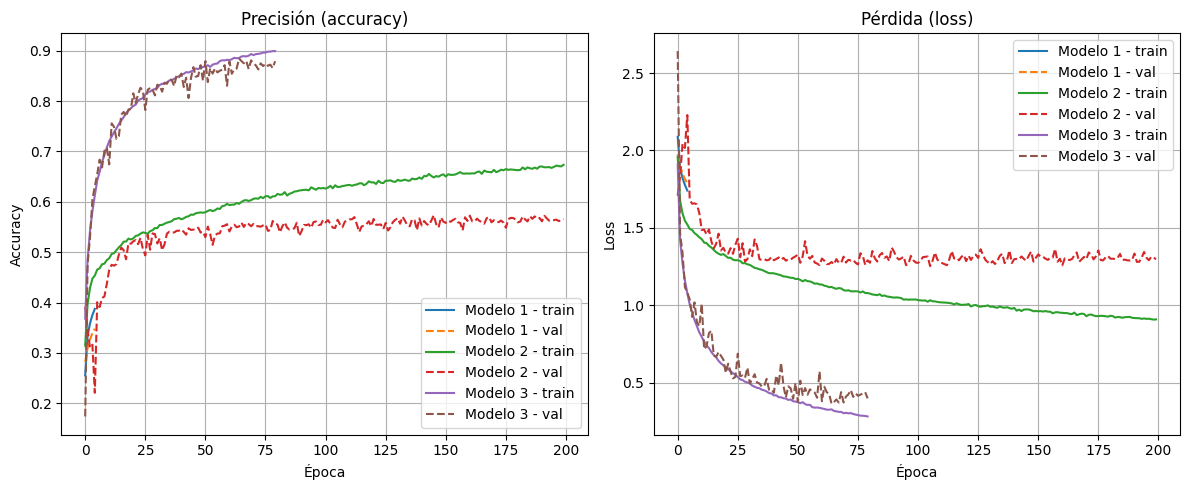

In [ ]:
import matplotlib.pyplot as plt

# Lista de tus histories y nombres para la leyenda
histories = [history1, history2, history3]
labels = ['Modelo 1', 'Modelo 2', 'Modelo 3']

# Accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
for i, h in enumerate(histories):
    plt.plot(h.history['accuracy'], label=f'{labels[i]} - train')
    plt.plot(h.history['val_accuracy'], linestyle='--', label=f'{labels[i]} - val')
plt.title('Precisión (accuracy)')
plt.xlabel('Época')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Loss
plt.subplot(1, 2, 2)
for i, h in enumerate(histories):
    plt.plot(h.history['loss'], label=f'{labels[i]} - train')
    plt.plot(h.history['val_loss'], linestyle='--', label=f'{labels[i]} - val')
plt.title('Pérdida (loss)')
plt.xlabel('Época')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()



---


## Discusiones



---



### ¿Existe sobreajuste? (responder 0,2 puntos y argumentar 0,8 puntos)

La respuesta es: **Si**

Observando las curvas de entrenamiento y validación:

* Modelo 1 y Modelo 3 muestran una clara separación entre las curvas de accuracy y loss a partir de cierta cantidad de épocas.
* Por ejemplo, el Modelo 1 alcanza una precisión de entrenamiento cercana al 90%, mientras que su precisión en validación se mantiene por debajo, con una brecha visible.
* En cuanto a la pérdida, el valor de train loss continúa bajando mientras que el val loss se estabiliza o incluso empeora ligeramente (especialmente visible en el Modelo 1 y 3).

Estos son síntomas clásicos de sobreajuste, donde el modelo aprende demasiado bien el conjunto de entrenamiento (memoriza), pero pierde capacidad de generalización en datos no vistos.

### ¿Qué tan bien funciona una red feedforward con imágenes? - 0,2 puntos

Una red feedforward (Modelo 2) funciona aceptablemente, pero no tan bien como una CNN especializada (como el Modelo 3). En el gráfico:
* El Modelo 2 alcanza una precisión de validación de 60%, mucho menor que los modelos convolucionales (88-90%).
* Esto se debe a que las redes feedforward no aprovechan la estructura espacial de las imágenes (por ejemplo, patrones locales, bordes, texturas), ya que cada píxel se trata como una característica independiente.
* En cambio, las CNNs capturan relaciones espaciales mediante filtros y son más eficientes para tareas de visión por computador.

Conclusión: **Las redes feedforward pueden ser un punto de partida, pero no son adecuadas para imágenes si se busca un rendimiento competitivo.**

### Limitaciones encontradas en el desarrollo del trabajo (indicar 3) - 0,6 puntos

* **Capacidad limitada del modelo feedforward para imágenes:** La red neuronal completamente conectada (FFN) no logró capturar características espaciales relevantes de las imágenes, lo que limitó su rendimiento comparado con modelos convolucionales. Esto es una desventaja inherente al tratar datos visuales con arquitecturas no especializadas.

* **Tiempo de entrenamiento elevado en modelos complejos:** Modelos como la CNN más profunda (Modelo 3) requirieron un mayor tiempo de entrenamiento, especialmente al usar técnicas como data augmentation y optimizadores avanzados. Esto hizo más lento el proceso de ajuste y validación. Sin optimizaciones de GPU y float16, puede tardar muchos dias.

* **Riesgo de sobreajuste en modelos de alta capacidad:** A pesar del uso de regularización (dropout, batch normalization), algunos modelos como el FFN o la CNN más grande presentaron señales de sobreajuste, con brechas claras entre la precisión en entrenamiento y validación.

---

## Penalizaciones
+ Ausencia de datos de autores - 10% de la calificación final
+ Falta de aplicación de buenas prácticas - 10% de la calificación final
+ Faltas en redacción y ortografía - 10% de la calificación final
+ Incumplimiento de rendimiento exigido - 50% de la calificación final

---